In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 6
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest', 'fold']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training fold']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=CFG.num_split, seed=CFG.SEED)):
    data.loc[val_ind, "fold"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development fold - fold {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation fold - fold {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training fold,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 3,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 3,37.32%,48.77%,6.38%,2.08%,5.44%
development fold - fold 4,37.32%,48.77%,6.38%,2.09%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['fold'].value_counts())

train_data = data[data['fold'].isin([i for i in range(CFG.num_split // 2)])]
test_data = data[~data['fold'].isin([i for i in range(CFG.num_split // 2)])]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
2.0    189806
0.0    189803
1.0    189803
3.0    189802
5.0    189799
4.0    189799
Name: fold, dtype: int64
Train data: 
Num of data: 569412
Num of unique id: 569412
Num of unique poi: 369987
Mean num of unique poi: 1.5390054245149154
Test data: 
Num of data: 569400
Num of unique id: 569400
Num of unique poi: 369985
Mean num of unique poi: 1.5389813100531102
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data.loc[data['fold'].isin([i for i in range(CFG.num_split // 2)]), col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.num_neighbors)
test_data = recall_knn(data.loc[~data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/208 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/211 [00:00<?, ?it/s]

Start knn
Num of unique id: 569412
Num of train data: 13915673
Pos rate: 0.07238543187957923
                        id          match_id     kdist  kneighbors  \
8923484   E_ac07eb8425d832  E_da4e754235066f  0.010416        15.0   
1656314   E_e88ded28a950c1  E_725f89d1d5b8aa  0.001993         2.0   
236011    E_6a34ea2b141ce8  E_6a34ea2b141ce8  0.000000         0.0   
11990738  E_6254310a793aeb  E_fc00718ae50c9f       NaN         NaN   
4083985   E_2c0ff67dde2999  E_8e2c4e2058bb01  0.000797         7.0   

         point_of_interest  fold  kdist_country  kneighbors_country  \
8923484   P_960413ff923cf6   1.0       0.008665                16.0   
1656314   P_b4309567c0de63   0.0       0.001965                 2.0   
236011    P_1b090242367e73   2.0       0.000000                 0.0   
11990738  P_41182e8be4e4e1   2.0       0.001177                16.0   
4083985                NaN   NaN            NaN                 NaN   

          kdist_diff  kneighbors_mean  label  
8923484     

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226622242687487


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0498778
[100]	valid_0's binary_logloss: 0.0482215
[150]	valid_0's binary_logloss: 0.0475032
[200]	valid_0's binary_logloss: 0.0470321
[250]	valid_0's binary_logloss: 0.0467566
[300]	valid_0's binary_logloss: 0.0464925
[350]	valid_0's binary_logloss: 0.046353
[400]	valid_0's binary_logloss: 0.0462741
[450]	valid_0's binary_logloss: 0.0461025
[500]	valid_0's binary_logloss: 0.0459353
[550]	valid_0's binary_logloss: 0.0458649
[600]	valid_0's binary_logloss: 0.0457699
[650]	valid_0's binary_logloss: 0.0456988
[700]	valid_0's binary_logloss: 0.0456128
[750]	valid_0's binary_logloss: 0.0455685
[800]	valid_0's binary_logloss: 0.0455182
[850]	valid_0's binary_logloss: 0.0454068
[900]	valid_0's binary_logloss: 0.0453611
[950]	valid_0's binary_logloss: 0.0452822
[1000]	valid_0's binary_logloss: 0.0452305
[1050]	valid_0's binary_logloss: 0.0451746

CV-accuracy: 0.98415196486063


In [ ]:
del train_data
gc.collect()

85

#Check Feature Importances

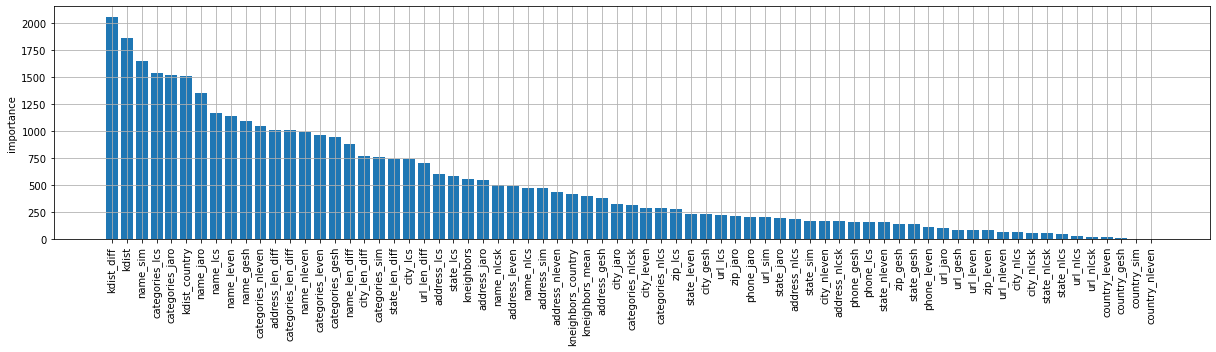

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 8.6 MB/s 
     |████████████████████████████████| 210 kB 48.1 MB/s 
     |████████████████████████████████| 78 kB 6.2 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 112 kB 55.1 MB/s 
     |████████████████████████████████| 146 kB 55.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=e60b2bd6c6dd244ebc399a751bc7da45cbe49309a8f1771cf625a51bc77e78a8
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-24 08:14:33,064] A new study created in memory with name: no-name-24f68a09-09ff-4dd2-ad86-d6fbbf6ec40b
[I 2022-05-24 08:15:10,120] Trial 0 finished with value: 0.8241922256062334 and parameters: {'threshold': 0.4358211001630762}. Best is trial 0 with value: 0.8241922256062334.


CV: 0.824192


[I 2022-05-24 08:15:31,349] Trial 1 finished with value: 0.8070993665856814 and parameters: {'threshold': 0.8322603219600423}. Best is trial 0 with value: 0.8241922256062334.


CV: 0.807099


[I 2022-05-24 08:15:52,583] Trial 2 finished with value: 0.8118457622061199 and parameters: {'threshold': 0.805506878526461}. Best is trial 0 with value: 0.8241922256062334.


CV: 0.811846


[I 2022-05-24 08:16:12,644] Trial 3 finished with value: 0.8068744864088916 and parameters: {'threshold': 0.8333899829871482}. Best is trial 0 with value: 0.8241922256062334.


CV: 0.806874


[I 2022-05-24 08:16:33,950] Trial 4 finished with value: 0.8272310768578404 and parameters: {'threshold': 0.5497320683609926}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.827231


[I 2022-05-24 08:16:56,093] Trial 5 finished with value: 0.7938692814603551 and parameters: {'threshold': 0.20043660843485878}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.793869


[I 2022-05-24 08:17:17,056] Trial 6 finished with value: 0.778650265301887 and parameters: {'threshold': 0.9199580826778782}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.778650


[I 2022-05-24 08:17:38,788] Trial 7 finished with value: 0.8264161126957782 and parameters: {'threshold': 0.6276269652181143}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.826416


[I 2022-05-24 08:18:00,072] Trial 8 finished with value: 0.8174721105610894 and parameters: {'threshold': 0.7628183002121919}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.817472


[I 2022-05-24 08:18:22,709] Trial 9 finished with value: 0.8247931192046846 and parameters: {'threshold': 0.4478017320317893}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.824793


[I 2022-05-24 08:18:50,029] Trial 10 finished with value: 0.6720810299617637 and parameters: {'threshold': 0.03529004818602216}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.672081


[I 2022-05-24 08:19:12,021] Trial 11 finished with value: 0.8268509672231642 and parameters: {'threshold': 0.6073255857137513}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.826851


[I 2022-05-24 08:19:32,550] Trial 12 finished with value: 0.8272103080874706 and parameters: {'threshold': 0.5505593086580939}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.827210


[I 2022-05-24 08:19:54,333] Trial 13 finished with value: 0.8132410753380251 and parameters: {'threshold': 0.3042646506827693}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.813241


[I 2022-05-24 08:20:15,437] Trial 14 finished with value: 0.8271146661428643 and parameters: {'threshold': 0.5927866789459799}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.827115


[I 2022-05-24 08:20:36,262] Trial 15 finished with value: 0.8141837829736555 and parameters: {'threshold': 0.31201075063760464}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.814184


[I 2022-05-24 08:20:58,122] Trial 16 finished with value: 0.8240072273016282 and parameters: {'threshold': 0.6847080058334185}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.824007
CV: 0.826738


[I 2022-05-24 08:21:20,625] Trial 17 finished with value: 0.8267376881635666 and parameters: {'threshold': 0.5068668991028741}. Best is trial 4 with value: 0.8272310768578404.
[I 2022-05-24 08:22:04,304] Trial 18 finished with value: 0.8186484499386191 and parameters: {'threshold': 0.35217926506269437}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.818648


[I 2022-05-24 08:22:28,030] Trial 19 finished with value: 0.7861652156690142 and parameters: {'threshold': 0.174430816372032}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.786165


[I 2022-05-24 08:22:47,256] Trial 20 finished with value: 0.7466385175326952 and parameters: {'threshold': 0.9630252791810496}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.746639


[I 2022-05-24 08:23:08,439] Trial 21 finished with value: 0.8272287478366303 and parameters: {'threshold': 0.5532764095590474}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.827229


[I 2022-05-24 08:23:29,875] Trial 22 finished with value: 0.8266360363099633 and parameters: {'threshold': 0.5027092720671881}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.826636


[I 2022-05-24 08:23:50,713] Trial 23 finished with value: 0.8220171147916916 and parameters: {'threshold': 0.7145912873289751}. Best is trial 4 with value: 0.8272310768578404.


CV: 0.822017


[I 2022-05-24 08:24:11,952] Trial 24 finished with value: 0.8273114396804023 and parameters: {'threshold': 0.5630125284765343}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.827311


[I 2022-05-24 08:24:34,462] Trial 25 finished with value: 0.8210946656595904 and parameters: {'threshold': 0.3808604284822815}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.821095


[I 2022-05-24 08:24:55,825] Trial 26 finished with value: 0.825151648276677 and parameters: {'threshold': 0.662428032300117}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.825152


[I 2022-05-24 08:25:17,331] Trial 27 finished with value: 0.8272687577438974 and parameters: {'threshold': 0.5566380308880334}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.827269


[I 2022-05-24 08:25:39,085] Trial 28 finished with value: 0.8230361462348577 and parameters: {'threshold': 0.4115300661900071}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.823036


[I 2022-05-24 08:26:00,458] Trial 29 finished with value: 0.8259367993865456 and parameters: {'threshold': 0.47735226976746553}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.825937


[I 2022-05-24 08:26:23,063] Trial 30 finished with value: 0.7973666054382785 and parameters: {'threshold': 0.21443832826071602}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.797367


[I 2022-05-24 08:26:43,323] Trial 31 finished with value: 0.8271559400041095 and parameters: {'threshold': 0.5442035867782542}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.827156


[I 2022-05-24 08:27:04,512] Trial 32 finished with value: 0.8272513354815616 and parameters: {'threshold': 0.5557131401521196}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.827251


[I 2022-05-24 08:27:25,344] Trial 33 finished with value: 0.8219110419738109 and parameters: {'threshold': 0.7159253250426838}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.821911


[I 2022-05-24 08:27:47,498] Trial 34 finished with value: 0.8259436399864877 and parameters: {'threshold': 0.6407825012115584}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.825944


[I 2022-05-24 08:28:13,597] Trial 35 finished with value: 0.8241064215551355 and parameters: {'threshold': 0.43402661308544954}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.824106


[I 2022-05-24 08:28:34,648] Trial 36 finished with value: 0.8151752044429998 and parameters: {'threshold': 0.7805733424721248}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.815175


[I 2022-05-24 08:28:55,207] Trial 37 finished with value: 0.8010352347626477 and parameters: {'threshold': 0.8591782911133903}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.801035


[I 2022-05-24 08:29:17,759] Trial 38 finished with value: 0.826933242956014 and parameters: {'threshold': 0.6040432788678125}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.826933


[I 2022-05-24 08:29:39,997] Trial 39 finished with value: 0.8272393083657816 and parameters: {'threshold': 0.5537222145800715}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.827239


[I 2022-05-24 08:30:02,297] Trial 40 finished with value: 0.825731203070149 and parameters: {'threshold': 0.4715024047746003}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.825731


[I 2022-05-24 08:30:23,973] Trial 41 finished with value: 0.8272026304844476 and parameters: {'threshold': 0.5517594825125646}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.827203


[I 2022-05-24 08:30:43,921] Trial 42 finished with value: 0.8209042716213617 and parameters: {'threshold': 0.7291444059235936}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.820904


[I 2022-05-24 08:31:04,933] Trial 43 finished with value: 0.8272355177511012 and parameters: {'threshold': 0.5814139726437194}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.827236


[I 2022-05-24 08:31:26,190] Trial 44 finished with value: 0.8270030553650994 and parameters: {'threshold': 0.5959115504790896}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.827003


[I 2022-05-24 08:31:46,198] Trial 45 finished with value: 0.8248520938163617 and parameters: {'threshold': 0.6677735925362254}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.824852


[I 2022-05-24 08:32:09,104] Trial 46 finished with value: 0.8270786296509691 and parameters: {'threshold': 0.5297619348427658}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.827079


[I 2022-05-24 08:32:40,962] Trial 47 finished with value: 0.8230717346384206 and parameters: {'threshold': 0.41202528052510534}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.823072


[I 2022-05-24 08:33:03,332] Trial 48 finished with value: 0.8272731790649231 and parameters: {'threshold': 0.5741744910082502}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.827273


[I 2022-05-24 08:33:23,499] Trial 49 finished with value: 0.826219874916662 and parameters: {'threshold': 0.633073447114626}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.826220


[I 2022-05-24 08:33:48,486] Trial 50 finished with value: 0.8259095228723587 and parameters: {'threshold': 0.47607664903240055}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.825910


[I 2022-05-24 08:34:09,770] Trial 51 finished with value: 0.8270785147921419 and parameters: {'threshold': 0.5938739145618113}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.827079


[I 2022-05-24 08:34:31,002] Trial 52 finished with value: 0.8272171945175459 and parameters: {'threshold': 0.5781697296157752}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.827217


[I 2022-05-24 08:34:52,412] Trial 53 finished with value: 0.8268154227648221 and parameters: {'threshold': 0.5097783073846194}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.826815


[I 2022-05-24 08:35:12,556] Trial 54 finished with value: 0.8235663058582151 and parameters: {'threshold': 0.6920729018295121}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.823566


[I 2022-05-24 08:35:34,381] Trial 55 finished with value: 0.8259433472807154 and parameters: {'threshold': 0.6407964289489709}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.825943


[I 2022-05-24 08:35:55,848] Trial 56 finished with value: 0.8272981835929507 and parameters: {'threshold': 0.5730701686879617}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.827298


[I 2022-05-24 08:36:18,965] Trial 57 finished with value: 0.8249777398509168 and parameters: {'threshold': 0.4514838584237697}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.824978


[I 2022-05-24 08:36:42,113] Trial 58 finished with value: 0.8195125072765238 and parameters: {'threshold': 0.3618965206604027}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.819513


[I 2022-05-24 08:37:04,433] Trial 59 finished with value: 0.8268079210253888 and parameters: {'threshold': 0.5123974094241083}. Best is trial 24 with value: 0.8273114396804023.


CV: 0.826808


[I 2022-05-24 08:37:26,278] Trial 60 finished with value: 0.8273153429566771 and parameters: {'threshold': 0.5635597865866974}. Best is trial 60 with value: 0.8273153429566771.


CV: 0.827315


[I 2022-05-24 08:37:48,028] Trial 61 finished with value: 0.8273227091560513 and parameters: {'threshold': 0.5637190289917348}. Best is trial 61 with value: 0.8273227091560513.


CV: 0.827323


[I 2022-05-24 08:38:09,013] Trial 62 finished with value: 0.8188111507144064 and parameters: {'threshold': 0.7515925756268681}. Best is trial 61 with value: 0.8273227091560513.


CV: 0.818811


[I 2022-05-24 08:38:29,092] Trial 63 finished with value: 0.8264965629594121 and parameters: {'threshold': 0.6248823980054788}. Best is trial 61 with value: 0.8273227091560513.


CV: 0.826497


[I 2022-05-24 08:38:50,905] Trial 64 finished with value: 0.8272652400830323 and parameters: {'threshold': 0.5747738011469099}. Best is trial 61 with value: 0.8273227091560513.


CV: 0.827265


[I 2022-05-24 08:39:12,621] Trial 65 finished with value: 0.8263723532312712 and parameters: {'threshold': 0.49119226335364286}. Best is trial 61 with value: 0.8273227091560513.


CV: 0.826372


[I 2022-05-24 08:39:32,786] Trial 66 finished with value: 0.8248037734120831 and parameters: {'threshold': 0.6689605546964604}. Best is trial 61 with value: 0.8273227091560513.


CV: 0.824804


[I 2022-05-24 08:39:54,055] Trial 67 finished with value: 0.8269932152964817 and parameters: {'threshold': 0.5248331031031208}. Best is trial 61 with value: 0.8273227091560513.


CV: 0.826993


[I 2022-05-24 08:40:15,985] Trial 68 finished with value: 0.8250128336571946 and parameters: {'threshold': 0.45194677004030026}. Best is trial 61 with value: 0.8273227091560513.


CV: 0.825013


[I 2022-05-24 08:40:37,192] Trial 69 finished with value: 0.8273348139417294 and parameters: {'threshold': 0.5720793894628918}. Best is trial 69 with value: 0.8273348139417294.


CV: 0.827335


[I 2022-05-24 08:40:57,281] Trial 70 finished with value: 0.8267480585819387 and parameters: {'threshold': 0.6143214835146096}. Best is trial 69 with value: 0.8273348139417294.


CV: 0.826748


[I 2022-05-24 08:41:18,649] Trial 71 finished with value: 0.8273215871011573 and parameters: {'threshold': 0.571013706011243}. Best is trial 69 with value: 0.8273348139417294.


CV: 0.827322


[I 2022-05-24 08:41:41,143] Trial 72 finished with value: 0.8271126839978828 and parameters: {'threshold': 0.533626311993899}. Best is trial 69 with value: 0.8273348139417294.


CV: 0.827113


[I 2022-05-24 08:42:02,100] Trial 73 finished with value: 0.8254528488805497 and parameters: {'threshold': 0.655311924939511}. Best is trial 69 with value: 0.8273348139417294.


CV: 0.825453


[I 2022-05-24 08:42:23,169] Trial 74 finished with value: 0.8273558208974926 and parameters: {'threshold': 0.5665291461232987}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.827356


[I 2022-05-24 08:42:45,058] Trial 75 finished with value: 0.8273297394490428 and parameters: {'threshold': 0.5693941692564152}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.827330


[I 2022-05-24 08:43:13,163] Trial 76 finished with value: 0.8232338603966681 and parameters: {'threshold': 0.697467763791087}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.823234


[I 2022-05-24 08:43:43,838] Trial 77 finished with value: 0.7120097550507702 and parameters: {'threshold': 0.0570878197856895}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.712010


[I 2022-05-24 08:44:06,824] Trial 78 finished with value: 0.8264247099595765 and parameters: {'threshold': 0.49306037761029314}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.826425


[I 2022-05-24 08:44:28,002] Trial 79 finished with value: 0.8267756626254649 and parameters: {'threshold': 0.6133200412693895}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.826776


[I 2022-05-24 08:44:49,368] Trial 80 finished with value: 0.8270810146670324 and parameters: {'threshold': 0.5307266447000433}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.827081


[I 2022-05-24 08:45:10,854] Trial 81 finished with value: 0.8273219044174966 and parameters: {'threshold': 0.5703590926819115}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.827322


[I 2022-05-24 08:45:31,535] Trial 82 finished with value: 0.8273320407976044 and parameters: {'threshold': 0.5626109455688241}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.827332


[I 2022-05-24 08:45:53,823] Trial 83 finished with value: 0.8238295884362131 and parameters: {'threshold': 0.4272640294017376}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.823830


[I 2022-05-24 08:46:14,861] Trial 84 finished with value: 0.8269111799367177 and parameters: {'threshold': 0.6054505517736688}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.826911


[I 2022-05-24 08:46:37,217] Trial 85 finished with value: 0.8259489695056211 and parameters: {'threshold': 0.6403147328959826}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.825949


[I 2022-05-24 08:46:59,712] Trial 86 finished with value: 0.825565323632981 and parameters: {'threshold': 0.46433469507995734}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.825565


[I 2022-05-24 08:47:20,350] Trial 87 finished with value: 0.8273387244038879 and parameters: {'threshold': 0.5646212458059054}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.827339


[I 2022-05-24 08:47:41,765] Trial 88 finished with value: 0.8271104485961541 and parameters: {'threshold': 0.5345973331986253}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.827110


[I 2022-05-24 08:48:03,392] Trial 89 finished with value: 0.8264820530438304 and parameters: {'threshold': 0.4952730511900815}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.826482


[I 2022-05-24 08:48:25,443] Trial 90 finished with value: 0.8271154635140368 and parameters: {'threshold': 0.5897850636424924}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.827115


[I 2022-05-24 08:48:45,808] Trial 91 finished with value: 0.8273196373830132 and parameters: {'threshold': 0.5633347675323105}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.827320


[I 2022-05-24 08:49:06,955] Trial 92 finished with value: 0.8272083537819663 and parameters: {'threshold': 0.5501482029757452}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.827208


[I 2022-05-24 08:49:28,320] Trial 93 finished with value: 0.826873027732483 and parameters: {'threshold': 0.5145407524464856}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.826873


[I 2022-05-24 08:49:50,298] Trial 94 finished with value: 0.8273299725247011 and parameters: {'threshold': 0.5644021233190587}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.827330


[I 2022-05-24 08:50:11,586] Trial 95 finished with value: 0.8265693293997893 and parameters: {'threshold': 0.6225526381276076}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.826569


[I 2022-05-24 08:50:32,737] Trial 96 finished with value: 0.8256916577462609 and parameters: {'threshold': 0.6482101493501062}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.825692


[I 2022-05-24 08:50:54,205] Trial 97 finished with value: 0.8271284391960501 and parameters: {'threshold': 0.5894041295281788}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.827128


[I 2022-05-24 08:51:14,994] Trial 98 finished with value: 0.8261894135090043 and parameters: {'threshold': 0.48519223897447006}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.826189


[I 2022-05-24 08:51:36,377] Trial 99 finished with value: 0.8273143672707699 and parameters: {'threshold': 0.5635410080012837}. Best is trial 74 with value: 0.8273558208974926.


CV: 0.827314


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5665291461232987

In [ ]:
study.best_value

0.8273558208974926

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.827356


# 間違っているものの中身を見る

In [53]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,146324.000000,146324.000000,142114.000000,142114.000000,142114.000000,137161.000000,150832.000000,150832.0,150832.000000,150832.000000,...,150832.000000,150828.000000,150828.000000,150828.000000,150828.000000,150832.000000,150828.000000,150828.000000,150828.000000,1.508320e+05
mean,0.006093,6.297976,4.022285,0.003409,6.321151,0.400614,6.606231,1.0,0.262371,0.414667,...,0.998720,0.998793,0.002453,0.998782,1.997587,0.000027,0.001227,0.998793,0.998793,2.188373e-01
std,0.049260,5.292030,0.821619,0.023662,5.295450,1.619634,5.368228,0.0,0.309105,0.252229,...,0.035748,0.034381,0.069622,0.034705,0.068761,0.005150,0.034811,0.034381,0.034381,1.767372e-01
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.646958e-08
25%,0.000426,2.000000,3.000000,0.000323,2.000000,0.006206,2.000000,1.0,0.000000,0.208333,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,5.251884e-02
50%,0.001067,4.000000,4.000000,0.000827,4.000000,0.061620,5.000000,1.0,0.000000,0.400000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.840213e-01
75%,0.002963,10.000000,5.000000,0.002292,10.000000,0.318083,10.500000,1.0,0.510113,0.600000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,3.703417e-01
max,8.437902,19.000000,5.000000,2.388985,19.000000,122.013780,19.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,5.665287e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
1077012,E_e400e5ce79e35a,E_d18a097323e4e6,0.000208,1.0,P_6333662c18ca53,3.0,0.000203,1.0,2.498202e-02,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.332523
4385290,E_b3257c9343caa9,E_feaa8ed0dae07b,0.005053,7.0,P_0f1d99b2553cec,4.0,0.003444,4.0,4.671839e-01,5.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.026790
2171896,E_d035e674e36471,E_520302c1f80683,0.001584,3.0,P_800e7af30f05c8,4.0,0.001011,3.0,5.667984e-01,3.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.016997
4242564,E_734095d55b9ab8,E_3c790c9d8e6cb0,0.007953,7.0,P_8feb4aa536e711,5.0,0.007952,7.0,1.657361e-04,7.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.378229
1126970,E_fab58fae493135,E_6287eeace66677,0.000148,1.0,P_6c88f462d49059,5.0,0.000147,1.0,6.778287e-03,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.559862
936768,E_a4c2ae09d10354,E_4d17c7211e9b62,0.000091,1.0,P_90ef20e5412ab3,3.0,0.000090,1.0,5.833629e-03,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.155466
1825179,E_3470c668fdcd9d,E_f975bc5d88b02d,0.000962,3.0,P_b5ab9566af2c2a,3.0,0.000856,3.0,1.244395e-01,3.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.123782
593217,E_0abb54b29ee86c,E_5d501d54575d28,0.026588,1.0,P_d465d87a96c8e8,3.0,0.022057,1.0,2.054492e-01,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.341257
739204,E_4c397cfcafa86b,E_ed89ab039de0bc,0.000143,1.0,P_8006000105bc47,4.0,0.000126,1.0,1.370473e-01,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.179995
1611852,E_d46da5ed683f6d,E_c3b8ec582a7e00,0.001769,2.0,P_273da0dae85c5e,5.0,0.000740,1.0,1.391699e+00,1.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.530639


In [56]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1010191,E_e2ecfe751d4a46,Supermercado Nacional,-30.048751,-51.198626,NaN,NaN,NaN,NaN,BR,NaN,NaN,Big Box Stores,P_e683f310ed6c34,1,4.0
1053539,E_ecb9e53ad3a650,Nacional,-30.049670,-51.202948,"R. Vicente da Fontoura, 1135",Porto Alegre - Rs,RS,90640-001,BR,http://www.nacional.com.br,5139015233,Supermarkets,P_e683f310ed6c34,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
54410,E_0c2f3edb21b825,Кабинет Физики 344 Лицей,59.891170,30.485808,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_ea31bd4916573e,4,3.0
362578,E_517a92d3cd3841,русский язык 64,59.892349,30.487551,NaN,NaN,NaN,NaN,RU,NaN,NaN,High Schools,P_ea31bd4916573e,4,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
384775,E_567214ebb19941,Daytona Ale House,29.167084,-81.085558,NaN,Daytona Beach,FL,NaN,US,NaN,NaN,Restaurants,P_8701727b95514d,3,5.0
1076263,E_f1da326a0f6140,Miller's Ale House,29.176938,-81.083526,NaN,Daytona Beach,FL,NaN,US,NaN,NaN,American Restaurants,P_8701727b95514d,3,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
730581,E_a41d21535efbb1,Asda,53.269702,-3.49960,Saint Asaph,Kinmel Bay,Conwy County Borough,L L18,GB,https://www.asda.com,NaN,Supermarkets,P_9a0549b72d00a7,1,4.0
939617,E_d30adc7109cc70,Asda,53.311739,-3.52196,"St Asaph Avenue North, Kinmel Bay",Conwy County Borough,Conwy County Borough,LL18 5EQ,GB,https://www.asda.com,+441745343466,Supermarkets,P_9a0549b72d00a7,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
199350,E_2cba0c474238ff,MNC SKY VISION,-6.164439,106.763149,"Jl. Raya Panjang, blok Z3 Kedoya",Jakarta,NaN,NaN,ID,NaN,NaN,Buildings,P_bc771029218154,4,5.0
339499,E_4c4ec8884d8291,Indovision,-6.163943,106.764019,jl raya panjang z/III,jakarta barat,Indonesia,NaN,ID,NaN,NaN,"Buildings, Coworking Spaces",P_bc771029218154,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
239331,E_35b92ee27e6d45,Супермаркет Билла,55.865662,37.674992,NaN,NaN,NaN,NaN,RU,NaN,NaN,Grocery Stores,P_ab381ed62c889e,1,3.0
1067117,E_efd645002abf39,BILLA,55.866227,37.675756,"ул. Летчика Бабушкина, д. 24",Москва,NaN,NaN,RU,http://www.billa.ru/,4957857500,Supermarkets,P_ab381ed62c889e,1,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
47418,E_0a9bb4dbae51aa,Kabakça Et Restaurant,41.216996,28.364739,NaN,NaN,NaN,NaN,TR,NaN,NaN,Steakhouses,P_137b8e3949b52b,1,4.0
1037147,E_e905b3135e48d5,Hasan'ın Yeri Kabakça Et Restaurant,41.216603,28.364587,NaN,NaN,NaN,NaN,TR,NaN,NaN,Food Courts,P_137b8e3949b52b,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1013609,E_e3b87082db9cd9,Bola 1,3.269100,101.678910,NaN,NaN,NaN,NaN,MY,NaN,NaN,Afghan Restaurants,P_c63563624b85e8,4,5.0
1055412,E_ed29c876a19360,Bola 35,3.269098,101.678898,NaN,NaN,NaN,NaN,MY,NaN,NaN,"Gluten-free Restaurants, Hot Dog Joints, Itali...",P_c63563624b85e8,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
185061,E_2984b8ef228865,Villa Rei,39.228342,9.568345,NaN,Castiadas (CA),NaN,NaN,IT,NaN,NaN,Beaches,P_0fde27a511e6eb,2,3.0
686855,E_9a41c1289795a1,spiaggia santa giusta,39.237016,9.570529,NaN,Castiadas (CA),NaN,NaN,IT,NaN,NaN,Surf Spots,P_0fde27a511e6eb,2,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
509739,E_729a0dc2925299,ห้องเงียบกริบ,16.476975,102.823435,NaN,NaN,NaN,NaN,TH,NaN,NaN,College Libraries,P_312af213bc0f27,4,4.0
917701,E_ce239a9d4435ac,ห้องอะไรซักอย่าง,16.476862,102.823712,NaN,NaN,NaN,NaN,TH,NaN,NaN,Universities,P_312af213bc0f27,4,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
508333,E_724784a8d73fb7,BRI,0.533574,123.060329,KC Gorontalo,Gorontalo,Gorontalo,96112,ID,NaN,435824465,"Banks, Offices, Arcades",P_1ab529804be2bb,4,4.0
840524,E_bcc0c2b58aedab,BNI Cabang Gorontalo,0.535156,123.060577,Jln. Nani Wartabone Ex. Ahmad Yani,Kota Gorontalo,Indonesia,NaN,ID,NaN,NaN,Banks,P_1ab529804be2bb,4,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
64663,E_0e788f3f40c7d3,ilim yayma cemiyeti Genclik Merkezi,37.868345,32.505595,NaN,NaN,NaN,NaN,TR,NaN,NaN,Student Centers,P_8f3d7fab80eaf6,1,5.0
913662,E_cd3fbd9c75ec42,İYC Gençlik Merkezi Eğitim Merkezi,37.868481,32.505756,NaN,NaN,NaN,NaN,TR,NaN,NaN,Buildings,P_8f3d7fab80eaf6,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
569127,E_7fec5c816abd25,RSUD UNDATA Palu,-0.858292,119.884241,Jl. RE. Martadinata,Palu,Sulawesi Tengah,94117,ID,NaN,NaN,"Hospitals, Medical Centers, Doctor's Offices",P_367ddd88fa9dc4,4,4.0
587307,E_84006bd5e409dd,RS Undata Baru,-0.813178,119.878666,Jl. Trans Sulawesi,Palu,NaN,NaN,ID,NaN,NaN,Hospitals,P_367ddd88fa9dc4,4,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
117537,E_1a5d00a7f4645a,永和豆漿,25.045450,121.507515,漢口街二段30號,Taipei,Wanhua,NaN,TW,NaN,NaN,Chinese Breakfast Places,P_546b18102967d5,1,5.0
596515,E_8611b7e3098eb7,永和豆浆大王,25.044462,121.507511,NaN,Wanhua District,NaN,NaN,TW,NaN,NaN,Breakfast Spots,P_546b18102967d5,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
16018,E_039e3273305b61,V F W,32.443237,-84.970021,NaN,Columbus,GA,31901,US,NaN,NaN,Bars,P_c846a1682e07d3,2,3.0
528097,E_76ab19a486dacc,Vfw Commander Post,32.444215,-84.971812,1824 Victory Dr,Columbus,GA,31901,US,NaN,+17066876656,Food,P_c846a1682e07d3,2,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
42666,E_0989fbc5ebdfc8,Tram Linie 3,51.344220,12.372310,NaN,NaN,NaN,NaN,DE,NaN,NaN,Tram Stations,P_684f1dffe90943,1,3.0
909032,E_cc390fa6b99435,H Leipzig Hauptbahnhof,51.344355,12.380201,Willy-Brandt-Platz,Leipzig,NaN,04103,DE,http://lvb.de,34119449,"Tram Stations, Bus Stops",P_684f1dffe90943,1,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
222593,E_31fccf7b00be91,HoH Lounge Bodrum,37.178038,27.531666,MayaTatil Köyü 106/A,NaN,NaN,NaN,TR,NaN,NaN,Cocktail Bars,P_d6601169c9f5b1,1,5.0
844380,E_bda1ee7d61ec94,HoH Library Bodrum,37.178093,27.532001,Maya Tatil Köyü 106/A,NaN,NaN,NaN,TR,NaN,NaN,Libraries,P_d6601169c9f5b1,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
430475,E_60becb96b34534,ÖYZ Sahilyolu Şantiyesi,40.981702,28.905640,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_a39d16b1b29a7c,2,5.0
850487,E_beff04b6c30cad,zeytinburnu büyük yalı şantiyesi,40.984923,28.905156,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_a39d16b1b29a7c,2,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
725203,E_a2e648b1a3ed21,北野白梅町バス停,35.027313,135.731638,北区北野下白梅町,京都市,京都府,603-8326,JP,https://www.city.kyoto.lg.jp/kotsu/,+81570666846,Bus Stops,P_f297966dbafeda,1,3.0
992371,E_deee049f426e95,北野白梅町 A乗り場バス停,35.027460,135.732070,NaN,京都市,京都府,603-8325,JP,NaN,NaN,Bus Stops,P_f297966dbafeda,1,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
345037,E_4d8657414eea0b,"""центр детского творчества \""Ново-переделкинр\""""",55.645106,37.360187,"Чоботовская, 5, к.1",NaN,NaN,NaN,RU,NaN,NaN,Schools,P_2b0fd663d271b4,3,4.0
818289,E_b7c4a1c4800282,ЦДТ Ново-Переделкино Чоботовская 5 Корп 1,55.639262,37.350390,Чоботовская 5 Корп 1,Москва,NaN,NaN,RU,NaN,NaN,Schools,P_2b0fd663d271b4,3,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
44354,E_09ee55879e9687,Траллебус,50.510077,30.500155,"Оболонський просп., 20А",Київ,м. Київ,NaN,UA,http://trallebus.com,444283099,"Pubs, Bars",P_7796965e83a484,3,5.0
682595,E_9955398f6a2b1f,Паб Траллебус,50.512424,30.498731,Проспект Оболонский 20а,Киев,город Киев,02000,UA,http://trallebus.com,+380675977113,Bars,P_7796965e83a484,3,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1009351,E_e2b8085b21ef3b,R&D Technical Exchange Center,26.313988,50.115992,NaN,Dhahran,NaN,NaN,SA,NaN,NaN,Convention Centers,P_9d841316a2a980,1,5.0
1133819,E_fedc4a6116068c,Technical Exchange Center (bldg. 2288),26.314148,50.116167,NaN,NaN,NaN,NaN,SA,NaN,NaN,NaN,P_9d841316a2a980,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
897455,E_c997ad2ac48486,Picnic Shelter #3,33.651082,-82.372118,NaN,NaN,NaN,NaN,US,NaN,NaN,Lakes,P_d89437d5f1169c,4,5.0
1053872,E_eccc972ad75be5,Family Y Camp Lakeside,33.705904,-82.369626,NaN,NaN,NaN,NaN,US,NaN,NaN,Campgrounds,P_d89437d5f1169c,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
61266,E_0db7bd2b071aed,у репета 📝,55.750496,49.188950,NaN,Казань,NaN,NaN,RU,NaN,NaN,"Auditoriums, College Classrooms, Residential B...",P_5df9c1dff26fbf,1,3.0
484331,E_6cd7b538698b14,репет по матике,55.747846,49.188964,Ул. Хусаина Мавлютова 46,Казань,NaN,NaN,RU,NaN,NaN,"College Classrooms, Residential Buildings (Apa...",P_5df9c1dff26fbf,1,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
644793,E_90f09c72abe691,Tom n Jerry,1.440721,124.755173,Kartun,Amelia,North Sulawesi,NaN,ID,NaN,NaN,NaN,P_53465be36c7ba0,4,5.0
843764,E_bd7e6a90342bb9,aMeL sLeepY room,1.449800,124.769039,Bedroom,NaN,NaN,NaN,ID,NaN,NaN,Rest Areas,P_53465be36c7ba0,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
592725,E_8537f65da91237,Сбербанк,55.684889,37.297469,Можайское Шоссе 141,Одинцово,NaN,NaN,RU,NaN,NaN,Banks,P_dc3b9ebc708599,1,4.0
771828,E_ad5af9476d5ae8,Сбербанк,55.685430,37.302452,"Можайское ш., 112",Одинцово,NaN,NaN,RU,http://www.sberbank.ru,NaN,Banks,P_dc3b9ebc708599,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
26006,E_05d31133e73fbe,Oseng Oseng mercon dpn MNC tv,-6.290687,106.887771,Jlm taman Mini Pintu II,Jakarta Timur,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_f871f62cc815d6,4,5.0
808985,E_b5abf22502a975,Studio 4 MNCTV,-6.292520,106.889248,Jalan taman mini 2,Jakarta Capital Region,Jakarta Capital Region,13810,ID,NaN,NaN,"Auditoriums, Offices",P_f871f62cc815d6,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
866649,E_c2ad0b5e1dd7cb,UKS SMAN 4 Bandung,-6.919921,107.598478,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_f1ea3b66e2b8af,4,5.0
886955,E_c739305aaabcc8,SMAN 4 Bandung XI IPA 7 Bangku Ke 2 Deket Pintu,-6.919430,107.598620,Jl. Gardujati,Bandung,West Java,NaN,ID,NaN,NaN,High Schools,P_f1ea3b66e2b8af,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
96268,E_159672a8c20fae,İmren Han Otel Lojman,38.286789,26.376048,NaN,NaN,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_10a765564bb3b9,1,5.0
1095651,E_f64015d7dc1f89,Personel Lojmanları,38.286792,26.376094,İmren Han Otel,Çeşme,İzmir,NaN,TR,NaN,NaN,Housing Developments,P_10a765564bb3b9,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
236753,E_35267ab968e4df,Pasar baru jakarta,-6.163622,106.833426,Jalan pasar baru,Jakarta pusat,Jakarta,NaN,ID,NaN,NaN,"Thrift / Vintage Stores, Flea Markets",P_679665f186eb27,4,3.0
484375,E_6cdaec4681f9dc,Pasar Baru (Passer Baroe),-6.163359,106.834434,Jalan Pasar Baru,Jakarta Pusat,DKI Jakarta,10710,ID,NaN,NaN,"Miscellaneous Shops, Clothing Stores",P_679665f186eb27,4,3.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,54824.000000,54824.000000,53365.000000,53365.000000,53365.000000,51733.000000,55935.000000,55935.0,55935.000000,55932.000000,...,55935.000000,55935.000000,55935.000000,55935.000000,55935.000000,55935.0,55935.000000,55935.000000,55935.000000,55935.000000
mean,0.006924,4.497538,3.997789,0.003389,4.513801,0.418740,4.747797,0.0,0.577679,0.608084,...,0.997712,0.997756,0.004505,0.997747,1.995513,0.0,0.002253,0.997756,0.997756,0.755340
std,0.068083,4.767559,0.816057,0.012469,4.774283,1.771437,4.900975,0.0,0.353147,0.245883,...,0.047783,0.047267,0.094817,0.047409,0.094535,0.0,0.047409,0.047267,0.047267,0.122287
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.566529
25%,0.000302,1.000000,3.000000,0.000229,1.000000,0.007625,1.000000,0.0,0.331271,0.444444,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.647455
50%,0.000926,2.000000,4.000000,0.000702,2.000000,0.066865,2.500000,0.0,0.648057,0.622222,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.743606
75%,0.003216,6.000000,5.000000,0.002443,6.000000,0.326527,7.000000,0.0,0.879902,0.800000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.857495
max,5.614628,19.000000,5.000000,0.533791,19.000000,94.986530,19.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,0.999938


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
10841094,E_0a2693421fcc64,E_f3069591384c81,0.001145,19.0,P_dd07faf735abb6,3.0,0.000922,17.0,0.241673,18.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.846816
1317303,E_501b6d0bc5f6ef,E_203f7b21cdf38d,0.000177,2.0,P_2a20151d6415b1,3.0,0.000176,2.0,0.001451,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.679712
1490354,E_9d9d22d1beeae6,E_b7379c9452fcc5,0.000165,2.0,P_123ee55cf4cea8,5.0,0.000165,2.0,0.000396,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.728126
1023570,E_cbebc7e06465df,E_818384b3da20e9,0.029024,1.0,P_aed8f36168cb72,4.0,0.028534,1.0,0.017182,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.727765
2343701,E_1da46aeabd7bbc,E_111f203c0608e7,0.006352,4.0,P_0418ea1965bd32,5.0,0.005581,9.0,0.138245,6.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.770207
768552,E_5968cdab519654,E_3ca7de12419fd0,0.000452,1.0,P_457e62702ba9d4,4.0,0.000448,1.0,0.010663,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.949757
10779912,E_ee7b4e679fd819,E_be999a630f96cc,0.001628,18.0,P_2ba06c37ee2ee6,5.0,0.001330,14.0,0.223872,16.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.699204
743410,E_4e1a3bb2ef3872,E_e6abeda82d0555,0.000108,1.0,P_068f348763d4db,5.0,0.000104,1.0,0.033700,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.844213
9546127,E_c39dab01927a65,E_061fe0094c5951,0.001634,16.0,P_f6d3c3d1fca10f,5.0,0.001502,14.0,0.087782,15.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.931457
3322721,E_d59ee0c72b3ad3,E_c2338a312fa313,0.000281,5.0,P_8520fbdcccf7d3,5.0,0.000264,5.0,0.065241,5.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.936139


In [57]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
759681,E_aaa83e4c13a1ef,AT&T,45.447276,-122.778595,9534 SW Washington Square Rd,Tigard,OR,97223,US,https://www.att.com/stores/oregon/tigard/2760,5035989048,"Mobile Phone Shops, Electronics Stores",P_f70debd3994c15,0,3.0
861696,E_c18bb9baf67e24,Soho Fashion Inc at Washington Square,45.449805,-122.781272,9585 SW Washington Square Rd,Tigard,OR,97223,US,http://www.sohostyle.com,NaN,NaN,P_0538610407627b,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
445992,E_643c06dcd3dcc2,ก๋วยเตี๋ยวเนื้อหน้า 29 shop (หน้าวังฯ),12.587916,99.950827,NaN,หัวหิน,NaN,NaN,TH,NaN,NaN,Noodle Houses,P_1d50e6cdc11df8,0,3.0
806681,E_b52793396d6966,ก๋วยเตี๋ยวแชมป์ (หน้าวัง),12.587999,99.950958,Petchakasem Rd,Hua Hin,Prachuap Khiri Khan,77110,TH,NaN,NaN,Noodle Houses,P_226f2311e62db2,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
45675,E_0a3813c7d43577,Anamur Devlet Hastanesi Çocuk Bölümü,36.078893,32.841825,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_11b16edb7b8198,1,5.0
454430,E_661fc7310f89e6,Anamed Hastanesi,36.078406,32.849596,Bahcelievler Mah. Ahmet Yesevi Bulv.,Mersin,Anamur,33640,TR,http://www.anamedhastanesi.com,3248144144,"Hospitals, Medical Centers",P_5307db2ac6c402,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
517056,E_74363e190060fd,dino Land Jatos,-6.934935,107.771846,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_d20bf4b6ebbee1,0,5.0
659738,E_943cc4543dc177,Jatos 21,-6.934777,107.771866,Jatinangor Town Square (JaToS),"Bandung, West Java",Jawa Barat,45363,ID,http://www.21cineplex.com,2287920089,"Multiplexes, Movie Theaters",P_83748fa5f3e029,4,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
174277,E_271756ccd78088,"A 112, Blok A, UiTM Arau",6.448709,100.278266,NaN,Arau,Perlis,02600,MY,NaN,NaN,NaN,P_8cb810e61b1d43,0,5.0
742057,E_a6b70d08f12c01,"LT 1, UiTM Arau",6.448561,100.277954,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Auditoriums,P_acd430f580acfe,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
292923,E_41c6ed65901462,7-Eleven,14.624419,121.048781,EDSA,Quezon City,NaN,NaN,PH,NaN,NaN,Convenience Stores,P_f200f02a5816b3,2,5.0
939254,E_d2f55bb50fad32,7-Eleven,14.620720,121.046743,EDSA cor Ermin Garcia,Quezon City,Metro Manila,NaN,PH,NaN,NaN,Convenience Stores,P_40274b3e83a564,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
142224,E_1fe1128f3076f4,Pasar Baru,-6.164259,106.832573,NaN,NaN,NaN,NaN,ID,NaN,NaN,Shoe Stores,P_679665f186eb27,4,3.0
711228,E_9fc02d139cde10,Pasar Baru Square,-6.163502,106.832556,NaN,NaN,NaN,NaN,ID,NaN,NaN,Shopping Malls,P_0488a67427df75,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
91635,E_148b6a2ef1b252,Puncak,-6.694246,106.967950,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_acc6dcafd067a9,4,5.0
728223,E_a394d7975f6fb0,Puncak Resort,-6.694143,106.965781,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_cf31751ef7f01f,4,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
489049,E_6dee33ce19265c,Евробет,41.52662,25.412085,"""ул. \""Маказа\"" № 13 А""",Момчилград,NaN,NaN,BG,http://t.co/DtSU5cNrs0,NaN,Betting Shops,P_78260a70d6c1a4,0,5.0
883369,E_c669c01c920613,Евробет,41.52688,25.412150,"""ул. \""Бенковски\"" № 5 """,Кърджали,NaN,NaN,BG,http://www.eurobet.bg,NaN,Betting Shops,P_def956dd5c6409,0,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
53077,E_0be1fc9de4383c,ที่ทำการไปรษณย์ประสานมิตร,13.740478,100.563071,สุขุมวิท 23,วัฒนา,กรุงเทพฯ,10110,TH,NaN,NaN,Post Offices,P_b63b3419c10d86,3,5.0
575833,E_8170a7f21d440c,ประสานมิตร พลาซ่า (Prasarnmit Plaza),13.740365,100.563000,Soi Sukhumvit 23,Vadhana,Bangkok,10110,TH,NaN,NaN,"Shopping Malls, Plazas",P_db3c94b79f04bb,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
307676,E_451c81fbb81ca3,ファミリーマート ハーバーランド駅店,34.678969,135.178722,中央区東川崎町1,Kobe,Hyōgo,650-0044,JP,https://www.family.co.jp,078-360-9080,Convenience Stores,P_1e04437ef3e34e,0,3.0
871610,E_c3c87160191c45,ファミリーマート 神戸ハーバーランド店,34.679221,135.181311,中央区東川崎町1-7-2,神戸市,兵庫県,650-0044,JP,https://www.family.co.jp,078-362-0801,Convenience Stores,P_b8c0118079e97b,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
283938,E_3fbf12cc312f48,Virgo 2 Function Room,1.257748,103.820157,Resorts World Convention Centre,Singapore,NaN,098269,SG,NaN,NaN,"Event Spaces, Convention Centers, Meeting Rooms",P_d2b3cdee57876f,0,3.0
1009154,E_e2aba3f5f32f46,Virgo 1 Function Room,1.257855,103.820071,Resorts World Convention Centre,Singapore,NaN,098269,SG,NaN,NaN,"Event Spaces, Convention Centers, Meeting Rooms",P_cd6a25cf341aba,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
745551,E_a77f224bcd524c,Bagno La Perla,43.933622,10.191783,NaN,NaN,NaN,NaN,IT,NaN,NaN,Beaches,P_8c52792c4a6cbe,0,5.0
1040006,E_e9a9cf4f2b256b,Bagno Ermione,43.929991,10.193978,NaN,Pietrasanta,Toscana,NaN,IT,NaN,NaN,Beaches,P_e59902d98f6fcb,0,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
157177,E_2336fc3343360a,Computer Lab2 @ Jss,1.332206,103.723335,NaN,NaN,NaN,NaN,SG,NaN,NaN,College Labs,P_e70ae60ffe53d4,0,5.0
1092184,E_f57581c5a12b7a,Computer Lab 3 @ JSS,1.330353,103.723274,NaN,NaN,NaN,NaN,SG,NaN,NaN,Indie Movie Theaters,P_38eb414dca60e7,0,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
470953,E_69d79740133848,Tingkat Seri Rapat 12,4.573379,101.102807,NaN,Ipoh,NaN,NaN,MY,NaN,NaN,NaN,P_be349e4a28163c,0,4.0
858526,E_c0d3b6c0a7f922,Tingkat Seri Rapat 1,4.573625,101.101423,Taman Maju Rapat,Ipoh,Perak,31350,MY,NaN,NaN,Housing Developments,P_79ef47f81f0cca,0,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
40877,E_092635f49fb962,@ ngagel dadi,-7.294107,112.747396,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_c1e1d3263387af,0,4.0
833275,E_bb20c0ab374c5c,Ngagel dadi 2,-7.293819,112.749392,Jl.ngagel Dadi 2c,Surabaya,indonesia,NaN,ID,NaN,NaN,Arcades,P_91177ba4a7ae47,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
10713,E_026f51b0c7fefb,Ciğ köfteci sait,40.752793,30.391266,Dogru sokak,NaN,NaN,NaN,TR,NaN,NaN,Fast Food Restaurants,P_13fbfdcd532910,0,5.0
568542,E_7fcc4234e089f2,Çiğ köfteci Sait,40.752310,30.390219,NaN,NaN,NaN,NaN,TR,NaN,NaN,Burrito Places,P_6dd6d57b453e8e,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
3005,E_00b3f78ddcf881,choc choc,41.940082,-87.645123,614 W Belmont Ave,Chicago,IL,NaN,US,NaN,NaN,Cosmetics Shops,P_6e87fa8e36ee43,0,5.0
751547,E_a8d5f0c3b3de98,Choc Choc,41.938337,-87.644363,3127 N Broadway St,Chicago,IL,60657,US,NaN,NaN,Cosmetics Shops,P_9ad099971819c5,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
287254,E_407e787153985d,"BS 3, CTF 4",1.465076,110.432240,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Academic Buildings,P_5dd9b72f070ec2,2,3.0
565091,E_7f00ef4e60b778,"BS 2, CTF 3, UNIMAS",1.463435,110.430704,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Academic Buildings,P_a54bbe6c5996f6,0,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
470079,E_69a58ec6db3b35,東京女子大学 2号館,35.709736,139.590808,NaN,NaN,NaN,NaN,JP,NaN,NaN,General Colleges & Universities,P_d20da4358853d4,0,4.0
603526,E_87a3fefd60ce06,東京女子大学,35.709352,139.591206,善福寺2-6-1,杉並区,東京都,167-8585,JP,http://www.twcu.ac.jp,0353826340,Universities,P_3e8966b14d341a,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
165981,E_2535b60a3ff393,Station herzele,50.897227,3.881007,NaN,NaN,NaN,NaN,BE,NaN,NaN,NaN,P_5c66e724f1cbd4,1,4.0
466345,E_68c8c9303ed4b4,Atheneum Herzele,50.891723,3.888291,De Tramzate 9,Herzele,NaN,9550,BE,http://www.atheneum-herzele.be,+3253622371,Middle Schools,P_41bd3f0dd3182e,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
750633,E_a8a10b6b43f7b8,เขาค้อทะเลหมอกรีสอร์ท,16.625249,100.993460,เขาค้อ,เพชรบูรณ์,ประเทศไทย,NaN,TH,NaN,NaN,"Resorts, Campgrounds",P_25e099fa86f83c,1,5.0
882784,E_c6474065c43351,ไร่หมอกน้อยใจลม@เขาค้อ,16.638632,100.987619,NaN,NaN,NaN,NaN,TH,NaN,NaN,Mountains,P_4af39b61c97147,0,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
190196,E_2aac5fa842102a,IAU - Central Library,26.393968,50.190292,King Faisal road,Khobar,Eastern Province,NaN,SA,http://www.uod.edu.sa,NaN,"Libraries, College Libraries",P_bd31307e37139f,0,3.0
589497,E_847fc0f0959336,مكتبة جامعة الدمام المركزية | UD Central Library,26.393965,50.189628,NaN,NaN,NaN,NaN,SA,NaN,NaN,College Libraries,P_1a41f55a0c0741,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
554753,E_7cae490fe1443b,J.CO Donuts & Coffe Buaran,-6.217710,106.924140,Ngurah Rai,NaN,NaN,NaN,ID,NaN,NaN,Donut Shops,P_36af293c942e0d,2,4.0
1114513,E_fa8da2bd5ba53d,Dunkin Donuts Buaran,-6.220516,106.923995,Jalan Raya Buaran Kel. Klender Kec. Duren Sawit,Jakarta Timur,DKI Jakarta,13470,ID,NaN,NaN,Donut Shops,P_7545b56810fa8a,3,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
3773,E_00de0738d0dd64,The Cabin Resort Langkawi,6.289258,99.728349,The Cabin Resort Langkawi,Langkawi,Kedah,07000,MY,NaN,NaN,Resorts,P_6b7e6de46c820f,1,4.0
131346,E_1d71697f81420f,Awana Langkawi Spa & Island Resort,6.289190,99.727886,Pantai Cenang,凌家卫岛,吉打,NaN,MY,NaN,NaN,Resorts,P_d1387291b4c798,3,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
58636,E_0d1d791f7c0689,Best Lube & Tune,34.106320,-117.448598,NaN,Fontana,CA,NaN,US,NaN,NaN,Automotive Shops,P_380d466296b74a,0,4.0
875562,E_c4ae0f450aae42,West Lube & Tune,34.106468,-117.448702,16319 Foothill Blvd,Fontana,CA,92335,US,NaN,9098234060,Automotive Shops,P_467b83feaaa3f2,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
479111,E_6bad0998e526b1,İsmail Abinin Yeri,41.065350,28.893988,NaN,NaN,NaN,NaN,TR,NaN,NaN,Cafés,P_b8577b69cd7d40,0,3.0
531962,E_778e36626b54d4,Kemal Abinin Yeri,41.062382,28.892075,Yildirim Mah,Ist,NaN,34170,TR,NaN,NaN,Cafés,P_b783256c965caa,0,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
232275,E_34226c119165ce,Ayala Malls Solenad,14.235280,121.057116,NaN,Santa Rosa,Laguna,NaN,PH,NaN,NaN,Outlet Malls,P_8450e29ef2b8e5,3,5.0
511889,E_731044c2514ac7,Ayala Malls Solenad Cinemas,14.236457,121.057453,"3/F Bldg C, Ayala Malls Solenad 3, Nuvali",City of Santa Rosa,Laguna,4026,PH,NaN,NaN,"Movie Theaters, Multiplexes",P_6eb0a5520cc845,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
25221,E_05a6b132dea514,Oğuzpark Cafe,39.777840,30.515088,Oğuzpark,Eskişehir,Türkiye,NaN,TR,http://www.oguzgiyim.com,+902222217042,Cafés,P_b8f5dfec3e3f9d,1,3.0
353210,E_4f5ec9c5eda393,Tango Cafe,39.778017,30.515031,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_90814fc9e23517,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
91152,E_14700753615426,Europcar Pozuelo Majadahonda,40.461435,-3.806512,"Avenida Monteclaro, Centro Comercial",Madrid,Urb. Valdelagua,28223,ES,https://www.europcar.es/es-es/oficinas/espana/...,+34680773175,Rental Car Locations,P_8dbad3b373630f,1,5.0
317713,E_47665a2e7b4e6c,vait sexta avenida,40.467724,-3.814577,NaN,NaN,NaN,NaN,ES,NaN,NaN,Cafés,P_ca1c52c2e3e219,0,4.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,852461.000000,852461.000000,844650.000000,844650.000000,844650.000000,267728.000000,854651.000000,854651.0,854651.000000,854650.000000,...,854651.000000,854647.000000,854647.000000,854647.000000,854647.000000,854651.0,854647.000000,854647.000000,854647.000000,854651.000000
mean,0.001479,1.012751,4.000951,0.000758,1.009289,0.432846,1.075944,1.0,0.819725,0.913415,...,0.999483,0.999581,0.000878,0.999564,1.999161,0.0,0.000439,0.999581,0.999581,0.963891
std,0.017521,2.642201,0.816055,0.005409,2.653855,1.798432,2.755233,0.0,0.347332,0.192646,...,0.022736,0.020138,0.041689,0.020790,0.040276,0.0,0.020844,0.020138,0.020138,0.084792
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.566532
25%,0.000000,0.000000,3.000000,0.000000,0.000000,0.007991,0.000000,1.0,0.843476,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.985489
50%,0.000000,0.000000,4.000000,0.000000,0.000000,0.070663,0.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999972
75%,0.000205,1.000000,5.000000,0.000146,1.000000,0.344223,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999991
max,4.111093,19.000000,5.000000,0.856283,19.000000,225.865403,19.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
287963,E_813598dc56f4d4,E_813598dc56f4d4,0.000000,0.0,P_f1b1273f966ba0,4.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999995
275597,E_7baf18073b7ea3,E_7baf18073b7ea3,0.000000,0.0,P_cd534d9164ae26,5.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999994
467939,E_d22340c03a1cfb,E_d22340c03a1cfb,0.000000,0.0,P_5b0d68982cf2af,4.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999994
1263174,E_37c36636b45285,E_3e286cab333beb,0.000246,2.0,P_f58be09f562d92,5.0,0.000246,2.0,1.509580e-03,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.998500
11211,E_0510f23181669d,E_0510f23181669d,0.000000,0.0,P_1b1436ffa756b6,3.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999991
263550,E_764305de29a05a,E_764305de29a05a,0.000000,0.0,P_2613712f6ccd74,5.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999995
1052567,E_d8f966ea6b69f8,E_95e0ecc015b5e8,0.000085,1.0,P_45a4e2d73cd16d,5.0,0.000080,1.0,6.385920e-02,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.985149
303982,E_8866c4cf05765e,E_8866c4cf05765e,0.000000,0.0,P_85382365d12aa1,5.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999956
540053,E_f2b26360e1b70c,E_f2b26360e1b70c,0.000000,0.0,P_9d05e347b3671e,5.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999984
1027263,E_cd98d5ff7eb5f3,E_0ff9b06083817c,0.000101,1.0,P_079957e035609d,4.0,0.000101,1.0,2.256216e-03,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.985762


In [58]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
785631,E_b07a9e4ea1c946,Luxor street,3.513739,98.660416,Jl.komplek luxor,Medan,Sumatera Utara,NaN,ID,NaN,NaN,Skate Parks,P_336844f67afa2b,4,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
169789,E_2611017b06b8c3,Sunglass Hut,34.07543,-118.377529,"8522 Beverly Blvd, Ste 678",Los Angeles,CA,90048,US,https://stores.sunglasshut.com/us/ca/los-angel...,3108551220,"Optical Shops, Accessories Stores",P_9382a764f1da50,0,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
486029,E_6d394aa7bcb609,PORTAKAL MARKET TALAS TOKİ,38.705640,35.550104,Yenidoğan Mh .,NaN,NaN,NaN,TR,NaN,NaN,Shopping Malls,P_a93e59319eb012,1,5.0
717237,E_a11c6e02a89a21,Portakal,38.701361,35.549623,Yenidoğan mh. Bilge Kağan cd.,Talas,Kayseri,38300,TR,NaN,NaN,Grocery Stores,P_a93e59319eb012,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
81957,E_12560b6a4207f0,RM AKA Cab. Lampung,-6.199862,106.782453,Jalan Kebon Jeruk Raya No. 11,Jakarta Barat,DKI Jakarta,11530,ID,NaN,215484350,"Diners, Indonesian Restaurants",P_f322f88b1cdcf6,0,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
437855,E_62683397e1ab01,streep center 15 norte,-33.008001,-71.547998,avenida benidorm,viña del mar,NaN,NaN,CL,NaN,NaN,Tech Startups,P_ad0f6e1a78c26d,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1091299,E_f53f5abdfa9111,KFC,25.831756,-80.216247,1190 NW 62nd St,Miami,FL,33150,US,http://www.kfc.com/,3057515389,"Fried Chicken Joints, Fast Food Restaurants",P_61e2fda94bc606,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1017609,E_e4a14124514075,Rumah Ice Cream,3.535153,98.662893,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_d3592b7596b146,2,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
148243,E_213d55f9d7d0d3,maRemaRe DAILYMARKET,35.533185,139.696390,日本,足立区,東京都,NaN,JP,NaN,NaN,Shoe Stores,P_f27a9eec5b4d25,1,3.0
1085660,E_f3f40f807eae7e,マーレマーレデイリーマーケット,35.533064,139.696111,幸区堀川町72-1,川崎市,神奈川県,212-8576,JP,https://maremare.jp/shop/60/,0448748333,"Shoe Stores, Clothing Stores",P_f27a9eec5b4d25,1,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
533490,E_77e61eb9276d3f,hotel 11 de septiembre,-33.429696,-70.622223,Avda. Providencia 1219,Santiago,NaN,NaN,CL,NaN,NaN,Bed & Breakfasts,P_4864a7940411e4,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
610597,E_894602b8b40ec3,McDonald's San Andres,14.570459,120.99226,NaN,NaN,NaN,NaN,PH,NaN,NaN,Fast Food Restaurants,P_cf13c640b2165c,2,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
496583,E_6f9e44cbe0335c,"Douglas Murray Campbell, MD",44.462096,-73.179863,6 San Remo Dr,South Burlington,VT,05403,US,https://www.uvmhealth.org/medcenter/provider/d...,+18028477855,Doctor's Offices,P_2f4fc42ac476a7,3,3.0
897725,E_c9a7b58066ea17,"Joelle Lynn Kraft, PA",44.462096,-73.179863,6 San Remo Dr,South Burlington,VT,05403,US,https://www.uvmhealth.org/medcenter/provider/j...,+18028477855,Doctor's Offices,P_2f4fc42ac476a7,3,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
86085,E_1348c2f56b160d,Sancaktar Kız Yurdu,39.702193,37.019201,Cumhuriyet Üniversitesi Yerleşkesi,Sivas,Sivas,NaN,TR,NaN,NaN,College Residence Halls,P_f290ddcc839eea,2,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
945958,E_d47aa8ff11d144,Alberto Marhetti Getaleria,45.059932,7.686466,NaN,NaN,NaN,NaN,IT,NaN,NaN,Ice Cream Shops,P_fa86a33eaebefe,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
291050,E_415c868f881ba4,宗像大社 沖津宮,34.241892,130.104089,大島沖之島,宗像市,福岡県,NaN,JP,NaN,NaN,Shrines,P_501fd99661cf10,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
750391,E_a8955351eeb9d9,Goodway Hotel Bali,-8.798023,115.206756,Jalan Dalem Tarukan No 7 Taman Mumbul,Badung,Bali,NaN,ID,http://www.goodwaybali.net/,361773808,Hotels,P_9398847e7c30c6,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
238375,E_3581188e77980d,Pimienta,13.730817,100.510786,NaN,NaN,NaN,NaN,TH,NaN,NaN,Tapas Restaurants,P_b2a48b7c5d91bd,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
214943,E_303f759dac469a,天ぷら筧,35.649694,139.686570,東山3-12-1,Meguro,Tōkyō-to,153-0043,JP,NaN,337157012,Japanese Restaurants,P_4bf0fb43f0e022,1,3.0
490270,E_6e358b4ae603e2,天ぷら 筧,35.649768,139.686474,東山3-12-1,目黒区,東京都,153-0043,JP,NaN,337157012,Tempura Restaurants,P_4bf0fb43f0e022,1,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
172293,E_26a3b4186468f6,"ул. Максима Горького, 60",52.982301,36.081671,"ул. Максима Горького, 60",Орёл,Орловская обл.,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_bf8c37191d1ac5,1,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
333562,E_4afa521609b184,Droga Raia,-23.605796,-46.662068,"Av. Lavandisca, 296",São Paulo,SP,NaN,BR,http://www.drogaraia.com.br,NaN,Pharmacies,P_73840ddd287ae4,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
782432,E_afbdd35b8a84bd,Banca Intesa,44.7731,20.481423,Kumodraška 174,Beograd,Central Serbia,11000,RS,http://www.bancaintesa.rs,113108888,Banks,P_4040c6c5ad9a27,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
998788,E_e05e33c0735b05,Pizza,26.197718,-81.800659,Tamiami Trl N,Naples,FL,34103,US,NaN,NaN,Pizza Places,P_072029b176980d,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
817782,E_b7a65d8dc1bf42,Berkant Kuaför,40.76437,29.928515,Ömerağa Mah. Alemdar Cad. Soydan İş Merkezi N:...,Kocaeli,NaN,NaN,TR,http://fbf.bz/b/6Hu,+902623350038,Salons / Barbershops,P_b9f13b1b1b7372,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
16464,E_03b945b11b7f2f,ร้านแกงใต้,13.821349,100.580349,Soi V.I.P,Chan Kasem,Bangkok,10900,TH,NaN,NaN,NaN,P_c198d08cde7ea8,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
79054,E_11aae1f450ffd3,Handwerkskammer Wiesbaden,50.082569,8.259712,Bierstadter Str. 45,Wiesbaden,NaN,65189,DE,http://www.hwk-wiesbaden.de,6111360,Non-Profits,P_8ac55f6269e206,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1039010,E_e9710f79510f84,Alpine Pro,50.052785,14.286411,Řevnická 121/1,Praha,Hlavní město Praha,155 21,CZ,https://www.alpinepro.cz,225986220,"Clothing Stores, Outdoor Supply Stores",P_69a2fa1eda168e,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
456936,E_66ada2ee6a4673,Mimarlık Fakültesi,40.994882,39.773638,Karadeniz Teknik Üniversitesi Kanuni Yerleşkesi,Trabzon,Trabzon,61030,TR,NaN,NaN,College Academic Buildings,P_7aa6b1a2dd1704,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
285833,E_402c3562351e44,Starbucks,40.76079,-73.830072,3805 Main St,Flushing,NY,11354,US,https://www.starbucks.com/store-locator/store/...,7184450354,Coffee Shops,P_7b08f0f5583b02,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
531468,E_7772158b461919,Royal Center Hotel - 5º Andar,-19.924562,-43.946824,NaN,NaN,NaN,NaN,BR,NaN,NaN,Hotels,P_0345439d402206,3,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
370201,E_532d4865c1f76a,Casafina,38.749017,-9.190935,NaN,NaN,NaN,NaN,PT,NaN,NaN,Dessert Shops,P_43b9586b17b339,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
479731,E_6bce1c25494d6f,"HR Services Unit, Bank Negara Malaysia",3.154471,101.693023,Jalan Dato' Onn,Kuala Lumpur,Federal Territory of Kuala Lum,50480,MY,NaN,NaN,NaN,P_05849ca7d42b2f,0,4.0


labelが0で0と予測しているもの

In [37]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,1.033439e+07,1.033439e+07,1.034219e+07,1.034219e+07,1.034219e+07,7.804618e+06,1.286343e+07,12863431.0,1.286343e+07,1.286340e+07,...,1.286343e+07,1.286334e+07,1.286334e+07,1.286334e+07,1.286334e+07,1.286343e+07,1.286334e+07,1.286334e+07,1.286334e+07,1.286343e+07
mean,4.621798e-02,1.027197e+01,3.999598e+00,1.745357e-02,1.026079e+01,4.163088e-01,1.078038e+01,0.0,1.874472e-02,1.928026e-01,...,9.962281e-01,9.964948e-01,7.205674e-03,9.964499e-01,1.992990e+00,6.530140e-06,3.602837e-03,9.964948e-01,9.964948e-01,8.807790e-03
std,3.241328e-01,5.360148e+00,8.164631e-01,5.806759e-02,5.364952e+00,2.056377e+00,5.237825e+00,0.0,9.874983e-02,1.285071e-01,...,6.130013e-02,5.800851e-02,1.185043e-01,5.888360e-02,1.160170e-01,2.555406e-03,5.925213e-02,5.800851e-02,5.800851e-02,4.097727e-02
min,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.655471e-25
25%,2.033085e-03,6.000000e+00,3.000000e+00,1.483764e-03,6.000000e+00,5.515838e-03,6.500000e+00,0.0,0.000000e+00,1.111111e-01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.547855e-05
50%,6.071478e-03,1.000000e+01,4.000000e+00,4.393133e-03,1.000000e+01,5.828090e-02,1.100000e+01,0.0,0.000000e+00,1.818182e-01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.278892e-04
75%,2.125771e-02,1.500000e+01,5.000000e+00,1.296937e-02,1.500000e+01,3.212428e-01,1.500000e+01,0.0,0.000000e+00,2.580645e-01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.860114e-03
max,4.718969e+01,1.900000e+01,5.000000e+00,3.044065e+00,1.900000e+01,1.902705e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.665286e-01


In [38]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
1934546,E_65a56610d0158d,E_3893a67c876a3c,0.000867,3.0,NaN,NaN,NaN,NaN,NaN,3.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,4.034523e-03
12887374,E_22909b61dd8ee8,E_700c26cff94f39,NaN,NaN,P_2ff24f3e200835,5.0,0.001978,1.0,NaN,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.669813e-07
5440894,E_8e01d13308fb6a,E_061b087319f8b0,0.000000,9.0,NaN,NaN,NaN,NaN,NaN,9.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,4.574681e-04
8976996,E_c3bc61975db08d,E_f9f8688eadee41,0.006284,15.0,P_5092c48308e4fa,4.0,0.005062,15.0,0.241496,15.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,3.145623e-04
9969462,E_82016c92a3608b,E_7076a258ec35db,0.003792,17.0,P_0a5209e69defde,3.0,0.003767,18.0,0.006774,17.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,7.264539e-04
11335286,E_e82798527dbc3c,E_5d5f654d01ee32,0.396382,19.0,NaN,NaN,NaN,NaN,NaN,19.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,9.606447e-05
11874083,E_53f64ada7eee84,E_baedbfa71d7321,NaN,NaN,P_8a075f182fcdc6,5.0,0.157114,18.0,NaN,18.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,6.095275e-06
6598963,E_967c55a5040787,E_0702cbe246361e,0.066929,11.0,NaN,NaN,NaN,NaN,NaN,11.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,4.064913e-07
11273214,E_cc2016478cb23e,E_edda040c508f68,0.000952,19.0,P_5e73c74940b494,5.0,0.000385,9.0,1.472247,14.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.063016e-03
4403790,E_bb7852ef4844ba,E_ce33ce04aa0d16,0.001118,7.0,P_4f3a142fc033a2,5.0,0.001118,7.0,0.000748,7.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.811329e-04


In [59]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
256974,E_39b4388b2c3451,ก๋วยเตี๋ยวเรือจอมพลัง RCA,13.749336,100.577318,NaN,Bang Kapi,Bangkok,10310,TH,NaN,NaN,"Asian Restaurants, Noodle Houses, Middle Easte...",P_499754aaaa341c,0,5.0
1079552,E_f2991f18cf87a1,อีสาน ล้านตำ,13.749500,100.577137,Rca,Huaykwang,Bangkok,NaN,TH,NaN,NaN,Thai Restaurants,P_e9fa527488d4c5,1,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
675433,E_97b8f8e123203a,Starbucks,19.549452,-99.286011,NaN,NaN,NaN,NaN,MX,NaN,NaN,Breakfast Spots,P_0590ba4aaaa590,1,3.0
732405,E_a48438f05b33e4,Tanning,19.552956,-99.291226,Espacio Esmeralda,Atizapan de Zaragoza,MEX,52930,MX,NaN,NaN,Tanning Salons,P_6bae8b3da5e9b0,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
594309,E_85922b6677b23f,宝満山頂上,33.539985,130.568989,NaN,NaN,NaN,NaN,JP,NaN,NaN,Mountains,P_eced7b6197a00a,1,3.0
671970,E_96f27dee15aeb8,福湊庵,38.699263,139.928963,羽黒町川代川代山406,鶴岡市,山形県,997-0131,JP,NaN,+81235624192,Soba Restaurants,P_d3e18381907e41,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
347723,E_4e23c6dc4e54e6,Günaydınnnn🎻📚☕,37.084860,37.327389,NaN,NaN,NaN,NaN,TR,NaN,NaN,Mediterranean Restaurants,P_2967b9558b9217,1,3.0
620481,E_8b82c5ac77c4e5,Eren Sitesi,37.086066,37.334958,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_97a3a23e6bee5a,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
270562,E_3cbf6fe58f21a8,Beğendik İskender & Kebap Salonu,38.675131,39.219471,Gazi Caddesi,Elazığ,Türkiye,NaN,TR,NaN,NaN,"Doner Restaurants, Kebab Restaurants",P_5569fc2d0eab78,0,5.0
359485,E_50c9d7157c4a4e,Garanti Bankasi Carsi Subesi,38.674997,39.221123,NaN,Elazig,NaN,NaN,TR,NaN,NaN,Banks,P_a96ef9937c0ae3,2,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
36942,E_084b1852e3a186,COS,39.935608,116.454195,三里屯路19号，三里屯太古里,北京,Beijing Municipality,100027,CN,NaN,NaN,Clothing Stores,P_a0cccbf86f5cec,3,4.0
442575,E_637645b29b2661,Embassy of Sweden - Visa Office,39.935627,116.449281,1 Gongti N Rd,Beijing,Beijing,NaN,CN,NaN,NaN,Embassies / Consulates,P_a19facebdce647,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
252497,E_38b60d414dffe3,Obchodní tiskárny Kolín,50.016592,15.214348,Plynárenská 233,Kolín,Czech Republic,280 02,CZ,NaN,NaN,"Buildings, Factories",P_397b53dba3638b,1,5.0
1102309,E_f7c07842ff34c1,Železniční stanice Kolín,50.025259,15.214173,Rorejcova 573,Kolín,NaN,280 02,CZ,http://www.cd.cz,NaN,Train Stations,P_576db489cc0808,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
195228,E_2bcd566876785b,Dr. Klein: Christoph Kuhnt,52.377705,9.722310,Königsworther Platz 2A,Hannover,Niedersachsen,30167,DE,https://www.drklein.de/berater/christoph-kuhnt...,+4951184489144,Financial or Legal Services,P_8af6b3df57114c,0,4.0
232084,E_341712578d54b1,artvinx GmbH Werbeagentur,52.366758,9.719696,Davenstedter Str.126,Hanover,NaN,30453,DE,https://www.artvinx.de,+4951145013727,"Print Shops, Design Studios, Advertising Agencies",P_e18826ae158890,1,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
97314,E_15d01cd617cb31,돈수백,37.503968,127.026049,강남대로110길 13,Gang-nam-gu,Seoul,06123,KR,http://www.donsoobaek.com,+8225393132,Korean Restaurants,P_2addfb51dfa06b,0,3.0
391834,E_5804b4feee8a4a,Themae SPA At Ritz Carlton,37.504899,127.027010,NaN,Seoul,NaN,NaN,KR,NaN,NaN,Spas,P_008fdaa317d216,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
785348,E_b06a4dae383845,PermataBank Tower III 5th Fl,-6.278110,106.72412,Bintaro,NaN,NaN,NaN,ID,NaN,NaN,Buildings,P_9557a474b7223c,4,3.0
896358,E_c958303a96f61b,Carrefour Bintaro,-6.279378,106.72402,NaN,NaN,NaN,NaN,ID,NaN,NaN,Department Stores,P_080c1fa2578661,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
670541,E_969f0cd30baf24,DNa MaxValu วังหิน,13.819257,100.592261,NaN,NaN,NaN,NaN,TH,NaN,NaN,General Entertainment,P_b1fb1a05a71cd5,1,3.0
737186,E_a59bb1f52797e7,พระยาภิรมย์คอนโด,13.820646,100.588915,รัชดา 36,Chatuchak,Bangkok,10900,TH,NaN,NaN,Residential Buildings (Apartments / Condos),P_b3649fb5963bfe,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
320468,E_4808d9b2290694,"Hong Leong Bank Business Centre Bukit Tinggi, ...",3.007238,101.437527,Jalan Batu Nilam 5,Klang,Selangor,41200,MY,NaN,NaN,Banks,P_cd40889de7c846,0,3.0
488810,E_6ddf9e05f0dd1e,Living Cabin,3.005785,101.440295,Tesco Klang,巴生,雪兰莪,41200,MY,NaN,0333239291,"Gift Shops, Arts & Crafts Stores",P_5b4d4a8d499883,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
576818,E_81ac11fd9a9b71,Redbox,30.500741,-90.107674,73626 Highway 25,Covington,LA,70435,US,http://www.redbox.com/locations/louisiana/covi...,8667332693,Video Stores,P_a89cef49f0bee8,0,3.0
1020738,E_e5543288d7f4cb,Pinnacle Lutheran School,43.079029,-77.581855,250 Pinnacle Rd,Rochester,NY,14623,US,NaN,NaN,Schools,P_a3931965524dd3,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
391685,E_57fd3724e679b7,3D Flooring & Design,32.566014,-97.142036,209 N Main St Ste 100,Mansfield,TX,76063,US,https://www.3dflooringstoremansfieldtx.com,+18174739865,"Home Services & Repairs, Construction & Landsc...",P_f125be8da007b7,1,4.0
536987,E_78abc966d696df,La Quinta Inn & Suites Mansfield,32.593142,-97.141145,1503 Breckenridge Rd,Mansfield,TX,76063,US,http://www.laquintamansfieldtx.com,8174535040,"Hotels, Business Centers",P_b3e4fdaf4348bb,1,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
450574,E_653f42f96c20c9,Subway World Exchange Plaza,45.421635,-75.697152,"111 Albert Street, Unit No 204A, 204B",Ottawa,ON,K1P 1A5,CA,https://restaurants.subway.com/canada/on/ottaw...,+16132317015,"Sandwich Places, Fast Food Restaurants, Restau...",P_41161ec0161c5c,0,3.0
563843,E_7eb7c5928404be,Wind Mobile,45.421325,-75.701669,240 Sparks Street,Ottawa,ON,K1A 0H5,CA,NaN,NaN,Mobile Phone Shops,P_c5ad5c4f47fb53,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
534514,E_78205611e45620,Mersin Marina,36.771604,34.568524,Eğriçam Mah. Adnan Menderes Blv. No:33,Mersin,Mersin,33160,TR,http://www.marinamersin.com,+903243300300,"Harbors / Marinas, Shopping Malls",P_8d2f8c73179d93,4,5.0
665792,E_959538fb8b85a8,Chefmezze Mersin,36.773313,34.570933,Adnan Menderes Bulvarı,Mersin,NaN,NaN,TR,NaN,NaN,Restaurants,P_0c09fc48e62a96,2,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
172960,E_26cbb5f0cb3f36,Yard,51.521829,-0.046477,140 tabernacle street,london,NaN,NaN,GB,NaN,NaN,NaN,P_237b85004062e0,0,5.0
372771,E_53c2d3f445cf9b,Food for Thought,51.521802,-0.046520,31 neal street,london,NaN,NaN,GB,NaN,NaN,NaN,P_b78bcbbd40f34a,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
736556,E_a577a5077daf07,NewDaysミニ 上田1号,36.396489,138.249823,天神1-1887,上田市,長野県,386-0025,JP,http://www.j-retail.jp,+81268224885,Convenience Stores,P_8b7e30c0d595a8,0,3.0
861217,E_c16f5b8deb758a,トーワ不動産建設,36.408733,138.247865,中央西2-2-20,Ueda,Nagano,NaN,JP,http://www.towa-fudosan.com,268252712,"Offices, Real Estate Offices",P_7fd607c0553e78,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
201073,E_2d1e8efb0d02ff,Smile Stylist,52.478912,-1.894391,"House of Fraser, Corporation St",Birmingham,West Midlands,B2 5JS,GB,NaN,+441616602312,Dentist's Offices,P_06a05218f02eb8,1,4.0
778950,E_aef7c523436e6a,Indian Streatery Express,52.477818,-1.894378,Unit 526 Central St,Birmingham,West Midlands,B5 4BU,GB,https://www.theindianstreatery.co.uk,+441216435334,"Indian Restaurants, Pop-Up Shops",P_eb4839fa8d4bd3,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
508252,E_7242f2ca882fdf,Town of Amherst Bldg A,43.047714,-78.718076,NaN,NaN,NaN,NaN,US,NaN,NaN,NaN,P_1ebddcf04f276e,1,5.0
1037453,E_e915c1d81990c3,Samantha's Shears,43.149853,-78.696136,5679 S Transit Rd,Lockport,NY,14094,US,http://www.samanthasshears.com,7164333323,Salons / Barbershops,P_f6bf66d48917cc,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
369360,E_52f89d1870d05e,Oficina - Canal 13 (C.A.),-33.427484,-70.626104,"Inés Matte Urrejola 0848, Providencia",Santiago,NaN,NaN,CL,NaN,NaN,Banks,P_521128398043b5,0,4.0
681536,E_991a2de6aa0948,Banco Santander - Clínica Santa María,-33.430272,-70.626469,Bellavista,Santiago,NaN,NaN,CL,NaN,NaN,Banks,P_56caa9af0bd497,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
589159,E_846c75ae706f64,Zeno Cafe & Bar,41.020409,28.973818,Galata,İstanbul,NaN,34100,TR,http://www.zenobar.net,2122928062,"Bars, Fish & Chips Shops, Seafood Restaurants",P_b57aa298e73aff,0,3.0
1004637,E_e1ad5818f76e12,Salaş Balık,41.022093,28.972675,Karaköy,NaN,NaN,NaN,TR,NaN,NaN,Restaurants,P_d1a012e2e8776f,0,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
453478,E_65e80474315898,Lily's Clothing Alteration Dry Clean Agency,-33.878582,151.205078,"Shop 6, Sussex Arcade, 631 George Street",Sydney,NSW,2000,AU,NaN,NaN,Dry Cleaners,P_22a2bbca9fd797,1,3.0
541791,E_79bdb325a4d34a,Iconic Estate,-33.879702,151.206848,501/451 Pitt Street,Sydney,NSW,2000,AU,NaN,NaN,Real Estate Offices,P_79d0922d8dec8b,0,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
627470,E_8d183284964f18,Trans Studio Mal,-6.934141,107.634267,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_6e7dd319013fa4,4,4.0
892181,E_c86b84de8e7e60,Cak Noor,-6.931092,107.634986,Karawitan,Bandung,Indonesia,NaN,ID,NaN,NaN,"Food Trucks, Indonesian Restaurants, Asian Res...",P_7b045a7ab85ab7,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1000434,E_e0b9359d0546b3,Costco Food Court,39.971718,-74.907607,NaN,NaN,NJ,NaN,US,NaN,NaN,Food Courts,P_31c6b0bd89a1a5,1,4.0
1123852,E_fca16b31af09b9,J. Fenimore Cooper Service Area,39.980836,-74.888520,New Jersey Turnpike,Mount Laurel,NJ,08054,US,NaN,NaN,"Rest Areas, Food Courts",P_e0f9cb530e2d5e,1,3.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
347947,E_4e316b892eb4bb,Central Park Hotel,51.565281,-0.102062,49 Queensborough Terrace,London,Greater London,NaN,GB,NaN,NaN,Hotels,P_6080f0215fe22c,1,3.0
591474,E_84f354754245dc,Rowans Tenpin Bowl,51.565324,-0.104914,10 Stroud Green Rd.,Finsbury Park,Greater London,N4 2DF,GB,http://rowans.co.uk,02088001950,Bowling Alleys,P_319d552a1661b1,1,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
163560,E_24a9a5737e8ebd,Warung Barokah,-7.459722,112.561750,Jl.Raya Prambon,Tarik,East Java,NaN,ID,NaN,NaN,Indonesian Restaurants,P_09abc5f66e04d9,0,5.0
259496,E_3a43831b62354c,Sungai brantas,-7.455285,112.451927,NaN,Mojokerto,East Java,NaN,ID,NaN,NaN,NaN,P_dbb873bb59b7db,0,4.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
645010,E_90fe4178a33653,Scarborough Open air Theatre,54.294800,-0.412314,"Northstead Manor Garden, Burniston Rd",Scarborough,NaN,YO12 6PF,GB,NaN,NaN,Amphitheaters,P_17ba7a72fe9f5e,1,3.0
714008,E_a0604ba8ed218b,Currys PC World Featuring Carphone Warehouse,54.265471,-0.415994,"Unit A, Seamer Road",Scarborough,North Yorkshire,YO12 4HE,GB,https://www.currys.co.uk/gbuk/index.html,+443445610000,"Electronics Stores, Mobile Phone Shops",P_03a688fa54ea48,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
334730,E_4b3b489c3d6a10,7-Eleven,22.358718,114.108360,"Shop 169, Maritime Square, 33 Tsing King Rd",Tsing Yi,Hong Kong,NaN,HK,NaN,85224952161,Convenience Stores,P_748e9c025920ec,0,3.0
402390,E_5a69edf7cf0fa9,靑衣城,22.358444,114.107382,新界青衣青敬路33號,Hong Kong,NaN,NaN,HK,NaN,NaN,Shopping Malls,P_35ae1633fa4855,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1016978,E_e47b6afe3a3964,OLFIN Car s.r.o.,50.195324,15.813735,Na Rybárně 1670,Hradec Králové,NaN,500 02,CZ,NaN,495000555,Auto Dealerships,P_e9e4e75b3728e6,0,3.0
1048289,E_eb8b50132be7ca,Pepco,50.212246,15.811632,Gočárova tř. 1754/48a,Hradec Králové,Královéhradecký kraj,500 02,CZ,http://www.pepco.cz,+420735179182,"Clothing Stores, Discount Stores",P_92ccca9e6d614f,0,3.0
